In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
df = pd.read_pickle('../data/player_stats.pkl')

In [3]:
df.head()

,Player,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,TOV,PF,PTS,ORtg,DRtg,Team,Season,Class,Pos,Height
0,Julian Edmonson,30,5.0,568,10.5,26.2,0.401,6.2,15.2,0.411,...,5.6,6.6,34.5,102.3,107.9,abilene-christian,2014,2.0,G,73.0
1,Jacob Lancaster,31,11.0,434,12.0,21.7,0.553,11.8,21.5,0.551,...,5.6,6.7,29.1,102.9,99.3,abilene-christian,2014,2.0,F,82.0
2,Parker Wentz,31,29.0,1040,7.7,15.7,0.491,3.2,5.6,0.576,...,3.4,4.0,24.5,124.7,107.5,abilene-christian,2014,1.0,G,69.0
3,LaDarrien Williams,16,14.0,474,8.1,21.8,0.371,6.4,16.3,0.389,...,4.2,5.2,24.4,101.2,104.1,abilene-christian,2014,2.0,G,72.0
4,Harrison Hawkins,16,16.0,481,6.8,18.1,0.374,3.7,10.4,0.353,...,6.0,5.8,24.1,100.9,108.5,abilene-christian,2014,2.0,G,72.0


## Functions

In [4]:
def guards(df):
    df = df[df['Pos'] == 'G']
    return df

In [5]:
def forwards(df):
    df = df[df['Pos'] == 'F']
    return df

In [6]:
def centers(df):
    df = df[df['Pos'] == 'C']
    return df

In [7]:
def drop_cols(df):
    df = df.drop(['G', 'GS', 'MP'], axis=1)
    return df

In [8]:
def ID(row):
    row['ID'] = ",".join([row['Team'], str(row['Season'])])
    return row

## Roster Counts

In [9]:
df.Pos.value_counts()

G    13323
F     8508
C     1480
Name: Pos, dtype: int64

In [10]:
df.dropna().Pos.value_counts()

G    11381
F     5599
C      489
Name: Pos, dtype: int64

## Reduced DateFrame

In [11]:
# Features to Cluster Centers
c_reduced_df_cols = ['Player', 'MP', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos', 'Height']

c_df_r = df[c_reduced_df_cols]

# Features to Cluster Forwards
f_reduced_df_cols = ['Player', 'MP', '2P', '2PA', '3P', '3PA', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos']

f_df_r = df[f_reduced_df_cols]

# Features to Cluster Guards
g_reduced_df_cols = ['Player', 'MP', '3P', 'AST', 'STL', 'TOV',
                     'PTS', 'TRB', 'Team', 'Season', 'Pos']

g_df_r = df[g_reduced_df_cols]

## Deal with NaNs

In [12]:
# Drop NaNs from reduced DataFrames
c_df_r = centers(c_df_r.dropna())
g_df_r = guards(g_df_r.dropna())
f_df_r = forwards(f_df_r.dropna())

## Vectorize dfs

In [13]:
def cluster_matrix(df):
    player = df['Player'].as_matrix()
    position = df['Pos'].as_matrix()
    X = df.drop(['Player', 'Team', 'Season', 'Pos'], axis=1).as_matrix()
    return X, player, position

In [14]:
X_c, player_c, position_c = cluster_matrix(c_df_r)
X_f, player_f, position_f = cluster_matrix(f_df_r)
X_g, player_g, position_g = cluster_matrix(g_df_r)

In [15]:
X_c_cols = c_df_r.drop(['Player', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_f_cols = f_df_r.drop(['Player', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_g_cols = g_df_r.drop(['Player', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()

## Standardize

In [16]:
scale = StandardScaler()
X_c = scale.fit_transform(X_c)
X_f = scale.fit_transform(X_f)
X_g = scale.fit_transform(X_g)

## Cluster

In [17]:
Ks = range(2, 10, 1)
km = [KMeans(n_clusters=i) for i in Ks]
sil_score_c = [silhouette_score(X_c, km[i].fit(X_c).labels_) for i in range(len(km))]
sil_score_f = [silhouette_score(X_f, km[i].fit(X_f).labels_) for i in range(len(km))]
sil_score_g = [silhouette_score(X_g, km[i].fit(X_g).labels_) for i in range(len(km))]

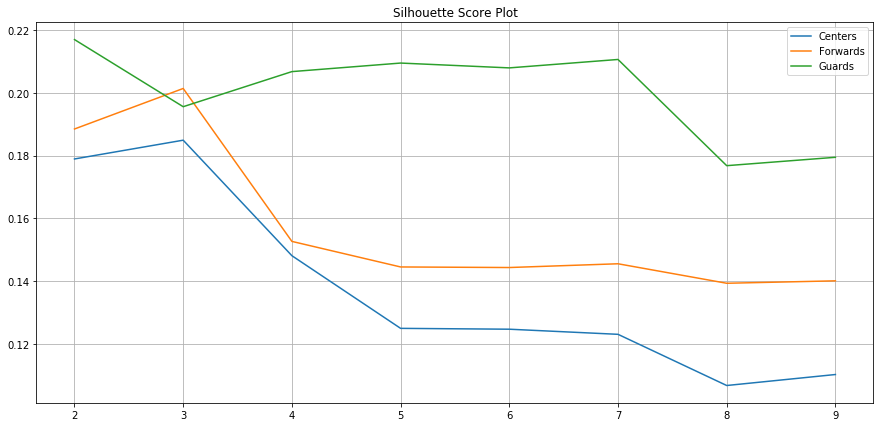

In [18]:
fig = plt.figure(figsize=(15, 7))
plt.plot(Ks, sil_score_c)
plt.plot(Ks, sil_score_f)
plt.plot(Ks, sil_score_g)
plt.legend(['Centers', 'Forwards', 'Guards'], loc='best')
plt.grid(True)
plt.title('Silhouette Score Plot');

In [19]:
ckmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
ckmeans.fit(X_c);

In [20]:
fkmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
fkmeans.fit(X_f);

In [21]:
gkmeans = KMeans(n_clusters=7, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
gkmeans.fit(X_g);

In [22]:
cclusters = ckmeans.labels_
fclusters = fkmeans.labels_
gclusters = gkmeans.labels_

In [23]:
center_labels_dict = {0: 'All Team Centers', 1: 'B Team Centers', 2: 'Shooting Centers'}
forward_labels_dict = {0: 'Deep Forwards', 1: 'Versatile Forwards', 2: 'Supporting Forwards'}
guard_labels_dict = {0: 'All team Guards', 1: 'Supporting Guards', 2: 'Utility 3 Point Shooter', 3: 'B Team Guard', 4: 'Rebounding Guard', 5: 'Utility Thief', 6: 'Benchwarmers'}

## Recompose player df with clusters

In [24]:
centers_df = c_df_r
centers_df['Cluster'] = cclusters
centers_df['Cluster_names'] = centers_df['Cluster'].map(center_labels_dict)
centers_df.head()

,Player,MP,2P,3P,TRB,AST,STL,BLK,TOV,PTS,Team,Season,Pos,Height,Cluster,Cluster_names
13,Zach Moer,52,8.2,0.0,9.4,5.9,1.2,4.7,5.9,24.7,air-force,2014,C,83.0,2,Shooting Centers
19,Darrius Parker,238,5.7,0.5,9.8,3.3,1.0,1.5,3.1,17.7,air-force,2014,C,79.0,1,B Team Centers
36,Pat Forsythe,595,7.2,0.0,11.6,1.7,1.4,3.4,4.8,17.2,akron,2014,C,83.0,2,Shooting Centers
37,Isaiah Johnson,414,6.8,0.0,12.7,1.8,1.2,4.0,2.8,17.2,akron,2014,C,82.0,1,B Team Centers
49,Justin Banks,408,6.6,0.0,17.7,0.9,1.0,4.4,3.0,17.7,alabama-am,2014,C,85.0,2,Shooting Centers


In [46]:
centers_df.groupby('Cluster_names')['MP', '2P', '3P', 'AST', 'STL', 'TOV', 'PTS', 'TRB', 'BLK'].mean().round()

,MP,2P,3P,AST,STL,TOV,PTS,TRB,BLK
Cluster_names,,,,,,,,,
All Team Centers,501.0,5.0,3.0,3.0,1.0,3.0,22.0,11.0,2.0
B Team Centers,231.0,4.0,0.0,1.0,1.0,4.0,12.0,13.0,3.0
Shooting Centers,601.0,9.0,0.0,2.0,1.0,4.0,23.0,16.0,3.0


In [29]:
forwards_df = f_df_r
forwards_df['Cluster'] = fclusters
forwards_df['Cluster_names'] = forwards_df['Cluster'].map(forward_labels_dict)
forwards_df.head()

,Player,MP,2P,2PA,3P,3PA,TRB,AST,STL,BLK,TOV,PTS,Team,Season,Pos,Cluster,Cluster_names
1,Jacob Lancaster,434,11.8,21.5,0.1,0.1,19.6,1.0,1.0,5.0,5.6,29.1,abilene-christian,2014,F,2,Supporting Forwards
5,James Pegues,445,7.2,15.8,0.1,0.8,13.4,2.1,2.9,0.4,6.1,20.9,abilene-christian,2014,F,2,Supporting Forwards
7,Alexsander Milosavljevic,127,7.9,14.9,0.0,0.5,15.4,1.4,0.0,1.4,4.7,17.7,abilene-christian,2014,F,2,Supporting Forwards
8,Austin Cooke,914,2.1,4.3,3.0,7.5,11.4,3.9,1.9,0.3,1.9,15.8,abilene-christian,2014,F,0,Deep Forwards
10,Riley Payne,584,3.9,8.3,0.0,0.0,7.9,2.4,1.8,0.3,3.3,11.1,abilene-christian,2014,F,1,Versatile Forwards


In [47]:
forwards_df.groupby('Cluster_names')['MP', '2P', '2PA', '3P', '3PA', 'AST', 'STL', 'TOV', 'PTS', 'TRB'].mean().round()

,MP,2P,2PA,3P,3PA,AST,STL,TOV,PTS,TRB
Cluster_names,,,,,,,,,,
Deep Forwards,552.0,4.0,8.0,3.0,9.0,3.0,1.0,3.0,21.0,10.0
Supporting Forwards,628.0,9.0,16.0,0.0,2.0,2.0,2.0,4.0,24.0,15.0
Versatile Forwards,257.0,4.0,8.0,0.0,2.0,2.0,1.0,3.0,11.0,12.0


In [34]:
guards_df = g_df_r
guards_df['Cluster'] = gclusters
guards_df['Cluster_names'] = guards_df['Cluster'].map(guard_labels_dict)
guards_df.head()

,Player,MP,3P,AST,STL,TOV,PTS,TRB,Team,Season,Pos,Cluster,Cluster_names
0,Julian Edmonson,568,4.3,3.0,2.3,5.6,34.5,5.7,abilene-christian,2014,G,0,All team Guards
2,Parker Wentz,1040,4.5,4.9,2.8,3.4,24.5,3.9,abilene-christian,2014,G,2,Utility 3 Point Shooter
3,LaDarrien Williams,474,1.7,7.7,2.4,4.2,24.4,10.5,abilene-christian,2014,G,5,Utility Thief
4,Harrison Hawkins,481,3.1,6.3,2.1,6.0,24.1,5.0,abilene-christian,2014,G,2,Utility 3 Point Shooter
6,Rafael Farley,421,4.6,1.7,0.6,2.5,18.7,4.9,abilene-christian,2014,G,0,All team Guards


In [35]:
guards_df.groupby('Cluster')['MP', '3P', 'AST', 'STL', 'TOV', 'PTS', 'TRB'].mean().round()

,MP,3P,AST,STL,TOV,PTS,TRB
Cluster,,,,,,,
0,270.0,5.0,3.0,2.0,3.0,26.0,6.0
1,206.0,1.0,3.0,2.0,3.0,12.0,7.0
2,902.0,3.0,5.0,2.0,4.0,23.0,7.0
3,3.0,2.0,3.0,0.0,47.0,11.0,12.0
4,3.0,0.0,6.0,33.0,6.0,22.0,8.0
5,430.0,1.0,8.0,2.0,5.0,14.0,6.0
6,14.0,1.0,3.0,1.0,5.0,17.0,29.0


## Team df

In [43]:
c = centers_df[['Player', 'MP', 'Team', 'Season', 'Cluster', 'Pos']]
f = forwards_df[['Player', 'MP', 'Team', 'Season', 'Cluster', 'Pos']]
g = guards_df[['Player', 'MP', 'Team', 'Season', 'Cluster', 'Pos']]
positions = [c, f, g]

In [44]:
teams = pd.concat(positions)

In [45]:
teams.head(50)

,Player,MP,Team,Season,Cluster,Pos
13,Zach Moer,52,air-force,2014,2,C
19,Darrius Parker,238,air-force,2014,1,C
36,Pat Forsythe,595,akron,2014,2,C
37,Isaiah Johnson,414,akron,2014,1,C
49,Justin Banks,408,alabama-am,2014,2,C
60,Fahro Alihodzic,767,alabama-birmingham,2014,2,C
68,Devonte' Neal,5,alabama-state,2014,2,C
93,Carl Engstrom,365,alabama,2014,1,C
102,John Puk,982,albany-ny,2014,2,C
115,Corey Young,61,alcorn-state,2014,0,C
